# CLIP Interrogator by [@pharmapsychotic](https://twitter.com/pharmapsychotic) 

<br>

What do the different OpenAI CLIP models see in an image? What might be a good text prompt to create similar images using CLIP guided diffusion or another text to image model? The CLIP Interrogator is here to get you answers!

<br>

If this notebook is helpful to you please consider buying me a coffee via [ko-fi](https://ko-fi.com/pharmapsychotic) or following me on [twitter](https://twitter.com/pharmapsychotic) for more cool Ai stuff. 🙂

And if you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [ ]:
#@title Check GPU
!nvidia-smi -L

In [ ]:
#@title Setup
!pip3 install ftfy regex tqdm transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
!pip3 install git+https://github.com/openai/CLIP.git
!git clone https://github.com/pharmapsychotic/clip-interrogator.git
!git clone https://github.com/salesforce/BLIP
%cd /content/BLIP

import clip
import gc
import io
import math
import numpy as np
import pandas as pd
import requests
import sys
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from models.blip import blip_decoder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

blip_image_eval_size = 384
blip_model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'        
blip_model = blip_decoder(pretrained=blip_model_url, image_size=blip_image_eval_size, vit='base')
blip_model.eval()
blip_model = blip_model.to(device)

def generate_caption(pil_image):
    gpu_image = transforms.Compose([
        transforms.Resize((blip_image_eval_size, blip_image_eval_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])(image).unsqueeze(0).to(device)

    with torch.no_grad():
        caption = blip_model.generate(gpu_image, sample=False, num_beams=3, max_length=20, min_length=5)
    return caption[0]

def image_embedding(image, model_name):
    model, preprocess = clip.load(model_name)
    model.cuda().eval()
    images = preprocess(image).unsqueeze(0).cuda()
    print(f"After preprocess: {images.shape}")
    with torch.no_grad():
        image_features = model.encode_image(images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

def load_list(name):
    with open(f"/content/clip-interrogator/data/{name}.txt", 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

def rank(model, image_features, text_array, top_count=1):
    top_count = min(top_count, len(text_array))
    text_tokens = clip.tokenize([text for text in text_array]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = torch.zeros((1, len(text_array))).to(device)
    for i in range(image_features.shape[0]):
        similarity += (100.0 * image_features[i].unsqueeze(0) @ text_features.T).softmax(dim=-1)
    similarity /= image_features.shape[0]

    top_probs, top_labels = similarity.cpu().topk(top_count, dim=-1)  
    return [(text_array[top_labels[0][i].numpy()], (top_probs[0][i].numpy()*100)) for i in range(top_count)]
        
def interrogate(image, models=['RN50','RN101','RN50x4','RN50x16','RN50x64','ViT-B/32','ViT-B/16','ViT-L/14']):
    caption = generate_caption(image)
    print(caption)

    table = []
    bests = [[('',0)]]*5
    for model_name in models:
        print(f"Interrogating with {model_name}...")
        model, preprocess = clip.load(model_name)
        model.cuda().eval()

        images = preprocess(image).unsqueeze(0).cuda()
        with torch.no_grad():
            image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        ranks = [
            rank(model, image_features, movements),
            rank(model, image_features, mediums),
            rank(model, image_features, ["by "+artist for artist in artists]),
            rank(model, image_features, trending_list),
            rank(model, image_features, flavors, top_count=3)
        ]

        for i in range(len(ranks)):
            confidence_sum = 0
            for ci in range(len(ranks[i])):
                confidence_sum += ranks[i][ci][1]
            if confidence_sum > sum(bests[i][t][1] for t in range(len(bests[i]))):
                bests[i] = ranks[i]

        row = [model_name]
        for r in ranks:
            row.append(', '.join([f"{x[0]} ({x[1]:0.1f}%)" for x in r]))

        table.append(row)

        del model
        gc.collect()
    display(pd.DataFrame(table, columns=["Model", "Movement", "Medium", "Artist", "Trending", "Flavors"]))

    flaves = ', '.join([f"{x[0]}" for x in bests[4]])
    print(f"\n\n{bests[0][0][0]} {bests[1][0][0]} of {caption}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}")


artists = load_list('artists')
flavors = load_list('flavors')
mediums = load_list('mediums')
movements = load_list('movements')
sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribble', 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
trending_list = [site for site in sites]
trending_list.extend(["trending on "+site for site in sites])
trending_list.extend(["featured on "+site for site in sites])
trending_list.extend([site+" contest winner" for site in sites])


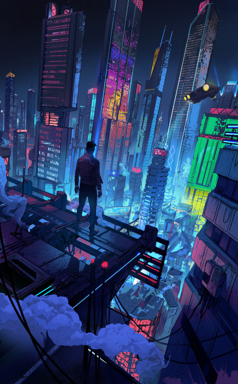

a man standing on top of a bridge over a city
Interrogating with ViT-B/32...
Interrogating with ViT-B/16...
Interrogating with RN101...
Interrogating with RN50x4...
Interrogating with RN50x16...


Model               Movement                 Medium  \
0  ViT-B/32  Retrofuturism (11.7%)  cyberpunk art (98.2%)   
1  ViT-B/16    Panfuturism (21.9%)  cyberpunk art (98.5%)   
2     RN101   Computer art (23.3%)  cyberpunk art (96.4%)   
3    RN50x4  Retrofuturism (26.6%)  cyberpunk art (97.9%)   
4   RN50x16    Panfuturism (65.3%)  cyberpunk art (99.7%)   

                      Artist                           Trending  \
0  by Vincent Lefevre (3.1%)  cg society contest winner (13.0%)   
1         by Syd Mead (0.7%)     behance contest winner (27.9%)   
2       by Reuben Tam (3.3%)     featured on Artstation (15.9%)   
3       by Reuben Tam (8.3%)   cgsociety contest winner (18.8%)   
4       by Reuben Tam (4.1%)  Artstation contest winner (32.0%)   

                                             Flavors  
0  synthwave (18.4%), darksynth (15.1%), dystopia...  
1  concept art (13.1%), dystopian art (9.0%), ret...  
2  voxel art (14.7%), artstation hq (13.6%), synt...  
3  artstation hq (20.5%), dystopian art (16.5%), ...  
4  synthwave (45.5%), retrowave (19.6%), 2d game ...



Panfuturism cyberpunk art of a man standing on top of a bridge over a city, by Reuben Tam, Artstation contest winner, synthwave, retrowave, 2d game art


In [12]:
#@title Interrogate!

#@markdown 

#@markdown #####**Image:**
image_path_or_url = "https://cdnb.artstation.com/p/assets/images/images/032/142/769/large/ignacio-bazan-lazcano-book-4-final.jpg" #@param {type:"string"}

#@markdown 

#@markdown #####**CLIP models:**
ViTB32 = True #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
ViTL14 = False #@param{type:"boolean"}
ViTL14_336px = False #@param{type:"boolean"}
RN101 = True #@param{type:"boolean"}
RN50 = True #@param{type:"boolean"}
RN50x4 = True #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}

models = []
if ViTB32: models.append('ViT-B/32')
if ViTB16: models.append('ViT-B/16')
if ViTL14: models.append('ViT-L/14')
if ViTL14_336px: models.append('ViT-L/14@336px')
if RN101: models.append('RN101')
if RN50: models.append('RN50x4')
if RN50x4: models.append('RN50x16')

if str(image_path_or_url).startswith('http://') or str(image_path_or_url).startswith('https://'):
    image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
else:
    image = Image.open(image_path_or_url).convert('RGB')

thumb = image.copy()
thumb.thumbnail([blip_image_eval_size, blip_image_eval_size])
display(thumb)

interrogate(image, models=models)
